#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

Импортируем все необходимые библиотеки, откроем наш датасет, в индексы передадим столбец datetime, затем отсортируем данные по дате, изучим их.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [2]:
try:
    data = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
except:
    data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
data.sort_index(inplace=True)

In [4]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Выполним ресемплирование данных по одному часу.

In [6]:
data = data.resample('1H').sum()

## Анализ

Проведем анализ наших данных, построим общий график заказов такси.

In [7]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


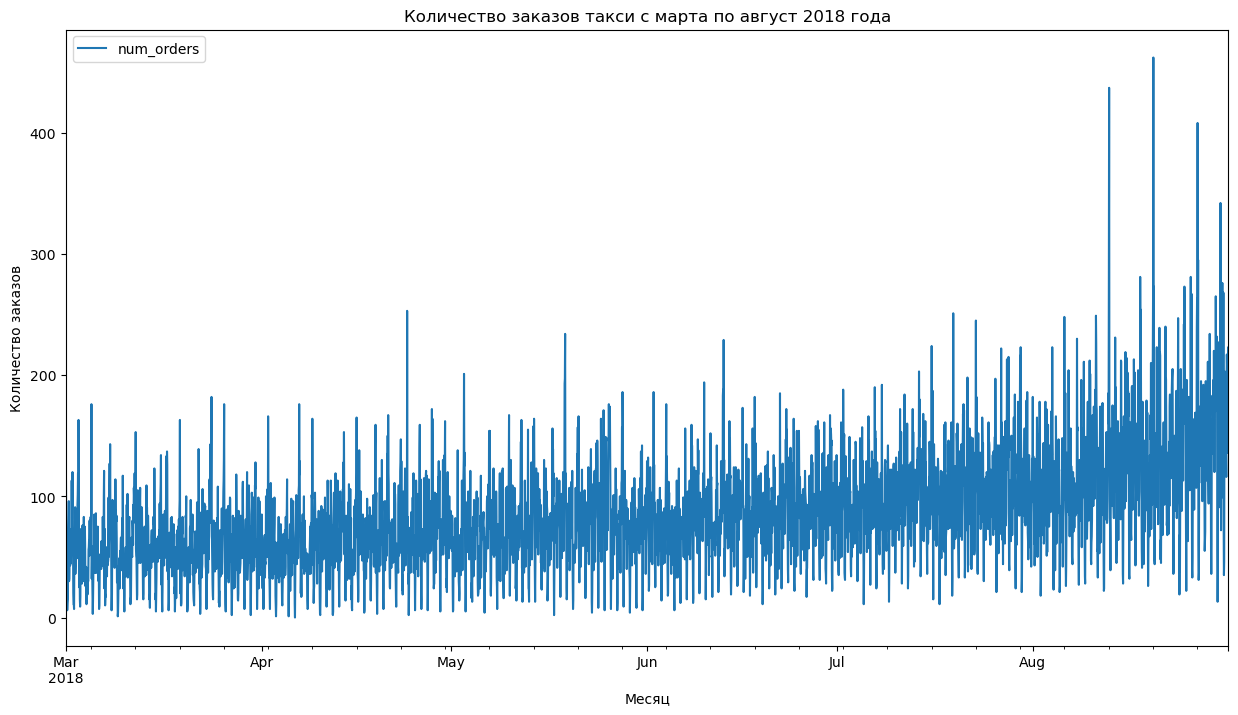

In [8]:
data.plot(figsize=(15,8))
plt.title('Количество заказов такси с марта по август 2018 года')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Изучим сезонность наших данных с помощью  seasonal_decompose(), построим график скользящего тренда, а также сезонную компоненту за первый месяц.

In [9]:
decomposed = seasonal_decompose(data)

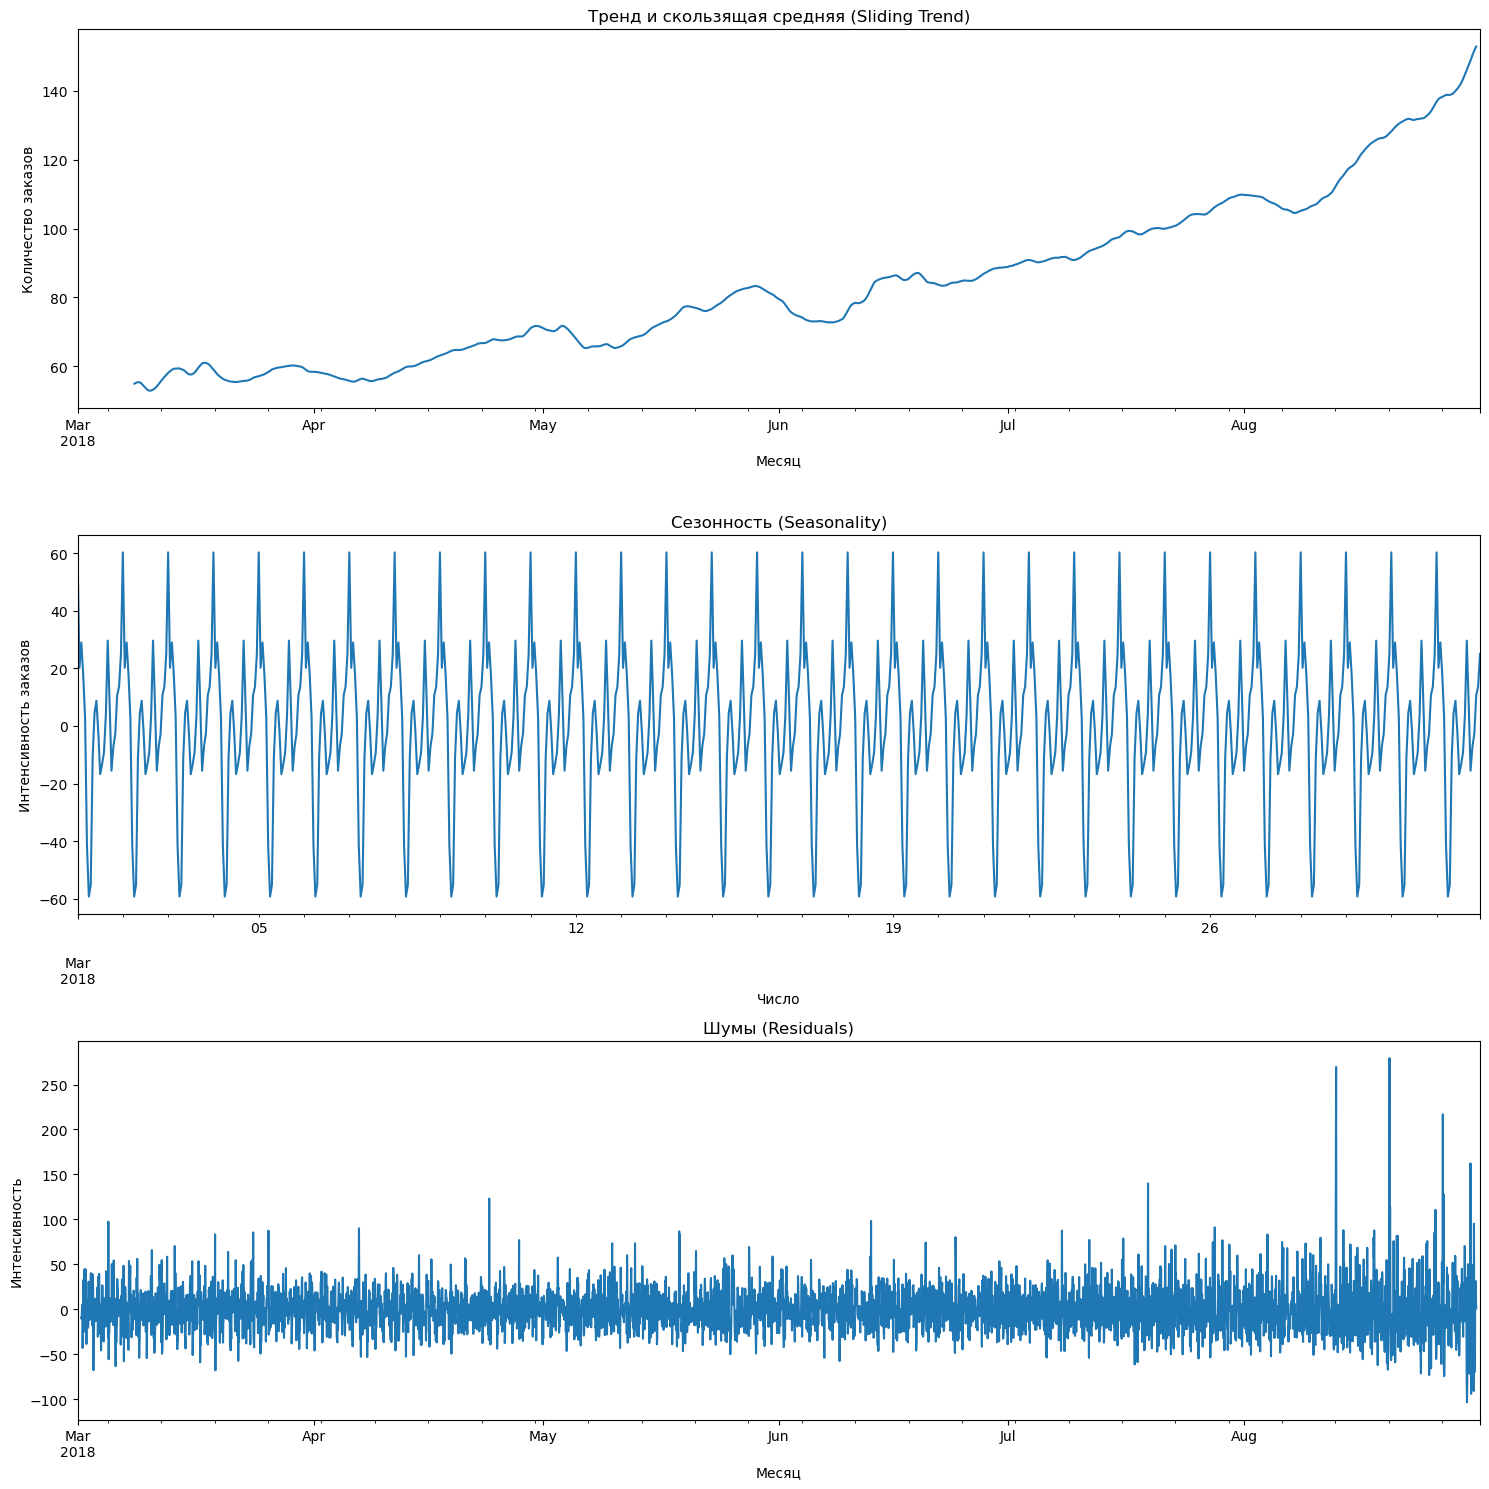

In [10]:
plt.figure(figsize=(15, 15))

plt.subplot(311)
decomposed.trend.rolling(168).mean().plot(ax=plt.gca())
plt.title('Тренд и скользящая средняя (Sliding Trend)')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')

plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-03-31'].plot(ax=plt.gca())
plt.title('Сезонность (Seasonality)')
plt.xlabel('Число')
plt.ylabel('Интенсивность заказов')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Шумы (Residuals)')
plt.xlabel('Месяц')
plt.ylabel('Интенсивность')
plt.tight_layout()

Изучим скользящее среднее и отобразим его на графике. Аргумент в функции rolling выберем равным 168 (кол-во часов в 1 неделе).

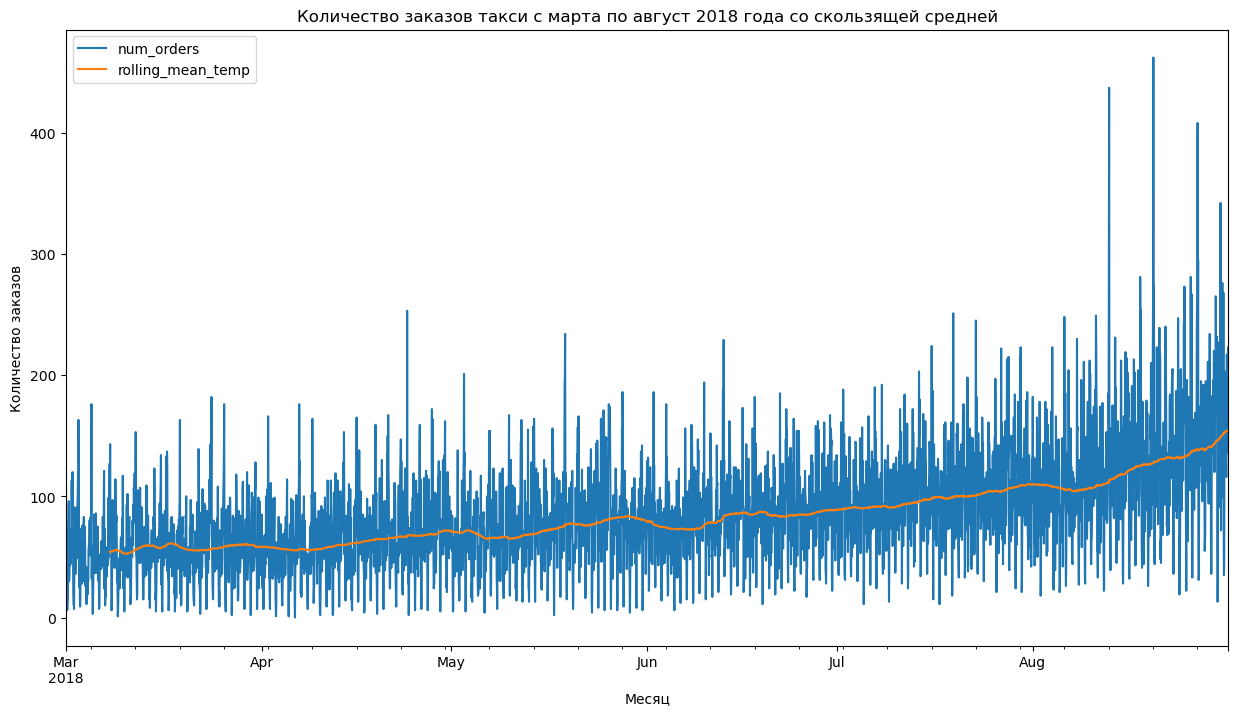

In [11]:
data['rolling_mean_temp'] = data['num_orders'].rolling(168).mean()
data.plot(figsize=(15, 8))
plt.title('Количество заказов такси с марта по август 2018 года со скользящей средней')
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')
plt.show()

Пока что удалим столбец со скользящей средней.

In [12]:
data = data.drop('rolling_mean_temp', axis=1)

Выводы:

1. Мы можем наблюдать тренд равномерного роста заказов за данный промежуток времени.
2. Также можем наблюдать сезонность ото дня в день: минимальное количество заказов ночью, есть пики с утра и днем, максимальный пик вечером.

## Обучение

Напишем функцию make_features(), чтобы прибавить к таблице новые признаки: год, месяц, день и день недели. Имена столбцов будут следующие: 'year', 'month', 'day', 'dayofweek'. Также добавим в эту функцию аргумент *max_lag*, который задаст максимальный размер отставания и аргумент *rolling_mean_size*, который задаст ширину окна для скользящего среднего.
Применим функцию к таблице с аргументом *max_lag* = 24, и *rolling_mean_size* = 1.

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(lag).mean()

In [14]:
make_features(data, 24, 1)

In [15]:
data.head(30)

,num_orders,year,month,day,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,0,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,2,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,4,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,2018,3,1,5,3,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,2018,3,1,6,3,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,2018,3,1,7,3,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,2018,3,1,8,3,15.0,12.0,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Разобъем наш датасет на обучающую и тестовую выборки в соотношении 9:1. Из обучающей выборки удалим строки с пропусками. Выделим фичи и целевой признак.

In [16]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()

target_train = train['num_orders']
target_test = test['num_orders']
features_train = train.drop(['num_orders'], axis=1)
features_test = test.drop(['num_orders'], axis=1)

Обучим наши модели.

### Ridge регрессия

Т.к. мы работаем с временными рядами, будем использовать *TimeSeriesSplit* для кросс-валидации.

In [17]:
cv_method = TimeSeriesSplit()

In [18]:
model_rr = Ridge()
model_rr.fit(features_train, target_train)

Ridge()

In [19]:
parameters_rr = {'alpha' : [0.1, 0.3, 0.5, 1, 5, 10],
                 'solver' : ['auto', 'svd', 'cholesky', 'lsqr','sparse_cg']}

In [20]:
model_rr = GridSearchCV(model_rr, param_grid=parameters_rr, cv=cv_method, scoring='neg_root_mean_squared_error')
model_rr.fit(features_train, target_train)
print(model_rr.best_params_)
print(-1*model_rr.best_score_)

{'alpha': 0.1, 'solver': 'auto'}
26.941355426470473


### Дерево решений

In [21]:
model_dt = DecisionTreeRegressor(random_state=12345)
model_dt.fit(features_train, target_train)

DecisionTreeRegressor(random_state=12345)

In [22]:
parameters_dt = {'splitter': ['best', 'random'],
                 'max_depth': [None, 1, 2, 3, 4, 5, 10, 20, 30],
                 'min_samples_leaf': [1, 2, 3, 4, 5, 6]}

In [23]:
model_dt = GridSearchCV(model_dt, param_grid=parameters_dt, cv=cv_method, scoring='neg_root_mean_squared_error')
model_dt.fit(features_train, target_train)
print(model_dt.best_params_)
print(-1*model_dt.best_score_)

{'max_depth': 10, 'min_samples_leaf': 5, 'splitter': 'random'}
28.86696593041064


### Случайный лес

In [25]:
model_rfr = RandomForestRegressor(random_state=12345)
model_rfr.fit(features_train, target_train)

RandomForestRegressor(random_state=12345)

In [26]:
parameters_rfr = {'max_depth': [None, 1, 2, 3, 4, 5],
                  'n_estimators': range(10, 101, 10)}

In [27]:
model_rfr = GridSearchCV(model_rfr, param_grid=parameters_rfr, cv=cv_method, scoring='neg_root_mean_squared_error')
model_rfr.fit(features_train, target_train)
print(model_rfr.best_params_)
print(-1*model_rfr.best_score_)

{'max_depth': None, 'n_estimators': 100}
25.245223971590004


## Тестирование

Нашей лучшей моделью оказалась модель случайного леса с параметрами n_estimators = 100, max_depth = None. Проверим ее на тестовой выборке.

In [30]:
model_rfr = RandomForestRegressor(random_state=12345, n_estimators = 100)
model_rfr.fit(features_train, target_train)
predictions_rfr = model_rfr.predict(features_test)
rmse_rfr = mean_squared_error(target_test, predictions_rfr)**0.5
print('RMSE для случайного леса', rmse_rfr)

RMSE для случайного леса 44.334064431366144


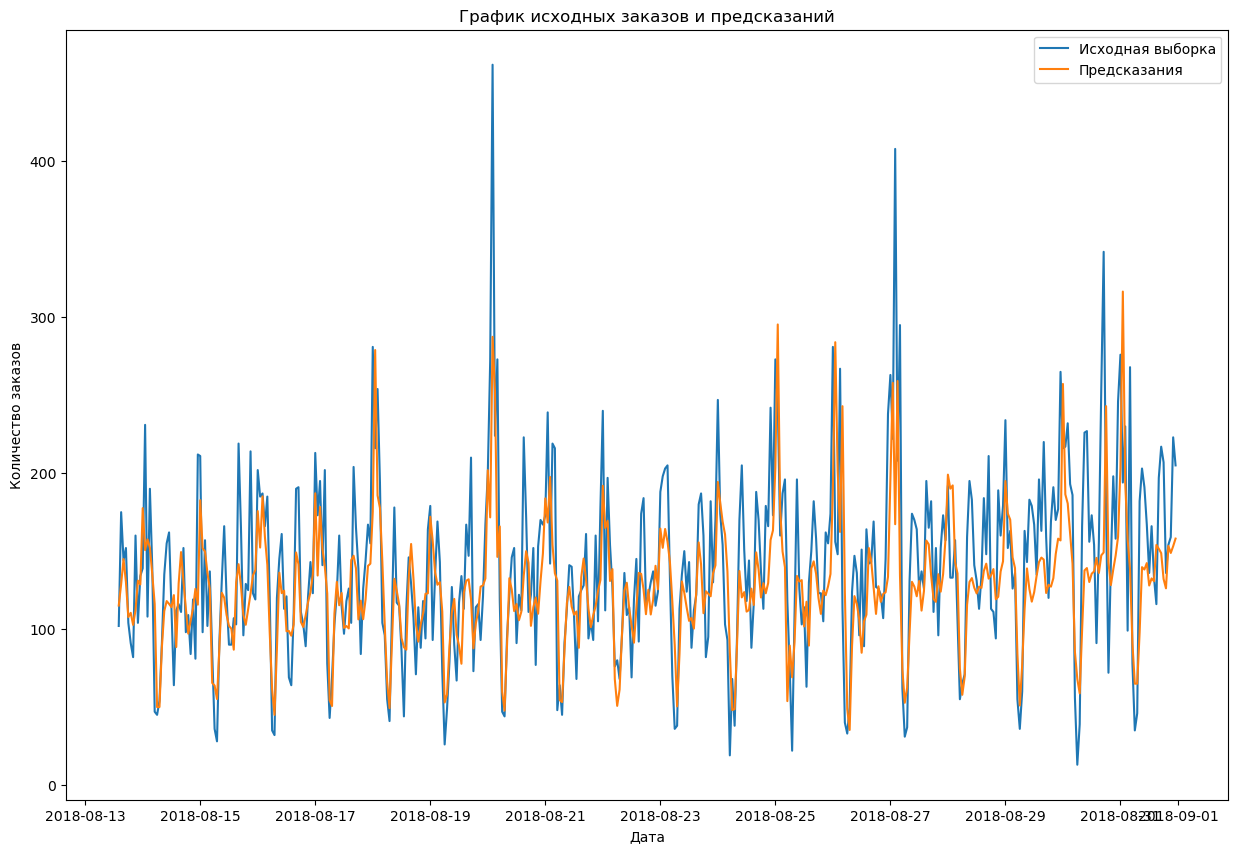

In [34]:
predictions_rfr = pd.Series(predictions_rfr, index=target_test.index)
plt.figure(figsize=(15,10))
plt.title('График исходных заказов и предсказаний')
plt.xlabel('Дата')
plt.ylabel('Количество заказов')
plt.plot(target_test, label='Исходная выборка')
plt.plot(predictions_rfr, label='Предсказания')
plt.legend()
plt.show()

### Выводы

В ходе текущей работы мы:
- открыли файл с данными, изучили его, выполнили ресемплинг и подготовку данных;
- провели анализ данных и визуализировали закономерности;
- выявили тренд роста заказов с марта по август;
- выявили сезонность в течение дня;
- добавили в данные новые признаки (день, месяц, год, час и день недели), добавили сдвиги и скользящую среднюю;
- разбили наши данные на тренировочную и обучающую выборки, выделили целевой признак и признаки;
- обучили различные модели, перебирая гиперпараметры;
- выявили самую лучшую модель - **RandomForestRegressor**, проверили ее на тестовой выборке, **RMSE** для случайного леса получили равным **44.33**, что является хорошим результатом.